# TP 4: Improve the Metropolis-Hastings algorithm

## Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#drive
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/MVA/Computational statistics/ASSIGNMENT /HW4/data')

Mounted at /content/drive/


# Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

MCMC samplers, such as the Metropolis-Hastings algorithm or Gibbs sampler, require that the user
specify a transition kernel with a given invariant distribution (the target distribution). These transition
kernels usually depend on parameters which are to be given and tuned by the user. In practice, it is often
difficult (if not impossible) to find the best parameters for such algorithms given a target distribution.
Moreover, if the parameters are not carefully chosen, it may result in a MCMC algorithm performing
poorly as in part A. Adaptive MCMC algorithms is a class of MCMC algorithms which address the
problem of parameters tuning by updating automatically some of (if not all) the parameters

## 1.A – Metropolis-Hastings within Gibbs sampler

We aim to sample the target distribution $\pi$, on $\mathbb{R}^2$, given by
$$
(x, y) \mapsto \pi(x, y) \propto \exp \left(-\frac{x^2}{a^2}-y^2-\frac{1}{4}\left(\frac{x^2}{a^2}-y^2\right)^2\right)
$$
$a>0$. We consider a Markov transition kernel $P$ defined by
$$
P=\frac{1}{2}\left(P_1+P_2\right)
$$
where $P_i\left((x, y) ; \mathrm{d} x^{\prime} \times \mathrm{d} y^{\prime}\right)$ for $i=1,2$ is the Markov transition kernel which only updates the $i$-th component: this update follows a symmetric random walk proposal mechanism and uses a Gaussian distribution with variance $\sigma_i^2$.

### Question 1



**Implement an algorithm which samples the distribution $P_1(z ; \cdot)$ where $z \in \mathbb{R}^2 ;$ likewise for the distribution $P_2(z ; \cdot)$. Then, implement an algorithm which samples a chain with kernel $P$.**



In [60]:
#target distribution 
log_target_dist = lambda x,y,a: -(x/a)**2-y**2-(1/4)*(((x/a)**2-y**2)**2)
#sample P1

def sample_P1(x,y,a,sigma):
    #sample a new x from the normal distribution with mean x and standard deviation sigma
    x_new = np.random.normal(x,sigma)
    y_new = y
    #compute the acceptance probability alpha
    alpha = np.exp(log_target_dist(x_new,y_new,a)-log_target_dist(x,y,a))
    #sample a uniform random number u from the uniform distribution on [0,1]
    if alpha > np.random.uniform(0,1):
        #if u < alpha return the new x and y and True for the acceptance
        return x_new,y_new,alpha,True
    else:
        #else return the old x and y and False for the acceptance
        return x,y,alpha,False


def sample_P2(x,y,a,sigma):
    #sample a new y from the normal distribution with mean y and standard deviation sigma
    x_new = x
    y_new = np.random.normal(y,sigma)
    #compute the acceptance probability alpha
    alpha = np.exp(log_target_dist(x_new,y_new,a)-log_target_dist(x,y,a))
    if alpha > np.random.uniform(0,1):
        return x_new,y_new,alpha,True
    else:
        return x,y,alpha,False

#sample with kenel P
#a function that samples from the distribution using sample_P1 and sample_P2 
def sample_P(N,a,p,sigma):    
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = np.random.uniform(-1,1)
    y[0] = np.random.uniform(-1,1)
    #initialize the acceptance rate for x and y
    acc_x = 0
    acc_y = 0
    #initialize the list of acceptance rates
    acc_rate_x = []
    acc_rate_y = []
    for i in range(1,N):
        #sample a new x and y from sample_P1 and sample_P2 with probability p
        u=np.random.uniform()
        if u<=p :
          x_new,y_new,alpha,acc = sample_P1(x[i-1],y[i-1],a,sigma[0])
          x[i] = x_new
          y[i] = y_new
          if acc: acc_x += 1
        else:
          x_new,y_new,alpha,acc = sample_P2(x[i-1],y[i-1],a,sigma[1])
          x[i] = x_new
          y[i] = y_new
          if acc:acc_y += 1
  
        # For each batch 
        if (i % 50 == 0) : 
            acc_rate_x.append(acc_x/50)
            acc_rate_y.append(acc_y/50)
            acc_x = 0 
            acc_y = 0 
    return x,y,acc_rate_x,acc_rate_y


### Question 2

**Run the algorithm with $a=10$ and standard deviations of the proposal distributions chosen as follows: $\left(\sigma_1, \sigma_2\right)=(3,3)$. Discuss the performance of the algorithm in this situation.**

In [86]:
def plot_all(N,a,p,sigma,dist, sample_func):

    x,y,acc_x,acc_y = sample_func(N,a,p,sigma)

    #plot the samples
    y_plot = np.linspace(-2,2,100)
    x_plot = np.linspace(-10,10,100)
    X,Y = np.meshgrid(x_plot,y_plot)
    Z = np.exp(dist(X,Y,a))
    plt.figure(figsize=(10,7))
    plt.title('Samples and target distribution')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.contour(X,Y,Z)
    plt.scatter(x,y,s=0.5)
    plt.show()

    #plot the acceptance rate 
    plt.figure(figsize=(10,7))
    plt.title('Acceptance rate, HM sampler')
    plt.xlabel('Number of samples')
    plt.ylabel('Acceptance rate')
    plt.plot(acc_x,label='x')
    plt.plot(acc_y,label='y')
    plt.legend()
    plt.show()

    #plot the autocorrelation
    plt.figure(figsize=(10,7))
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    pd.plotting.autocorrelation_plot(x,label='x')
    pd.plotting.autocorrelation_plot(y,label='y')
    plt.xlim((0,80))
    plt.show()

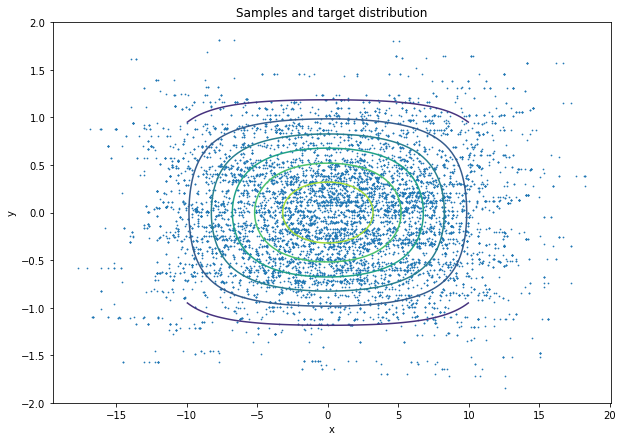

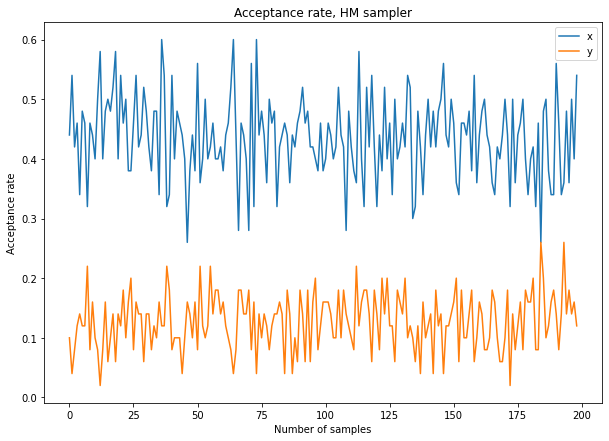

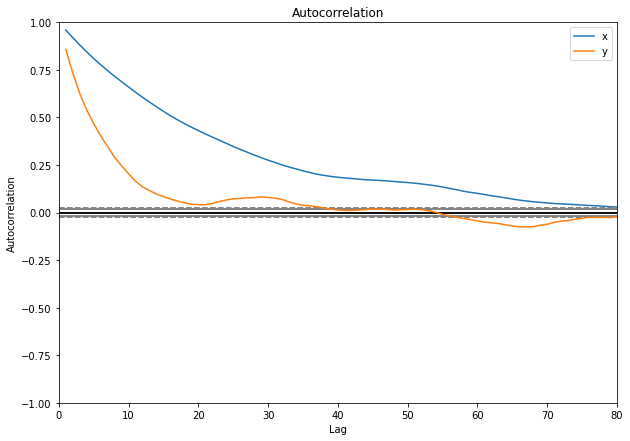

In [87]:
#test the function
N = 10000
a = 10
p=0.5
sigma = [3,3]
#plot the samples/ acceptance and correlation
plot_all(N,a,p,sigma,log_target_dist, sample_P)

> We notice that there are many samples outside the distribution 

> We notice that the acceptance rate is higher for x and isn't close to the optimal value 0.24. In other words the symetric kernel doesn't perform well since we stay is the same region and we dont explore enough. 

>The x-autocorrelation coordinate's plot displays non-convergence, indicating that the coupled and non-random nature of the points sampled along the x-axis. In other words, the x-axis variance is probably minimal. On the other hand, the y-coordinate autocorrelation plot begins to converge.

### Question 3 

**How could the performance of the above algorithm be improved ? Propose two methods.**



> We can adapt the parameters sigma and the probability of taking x higher that y since the graph is larger for x cordinnates 



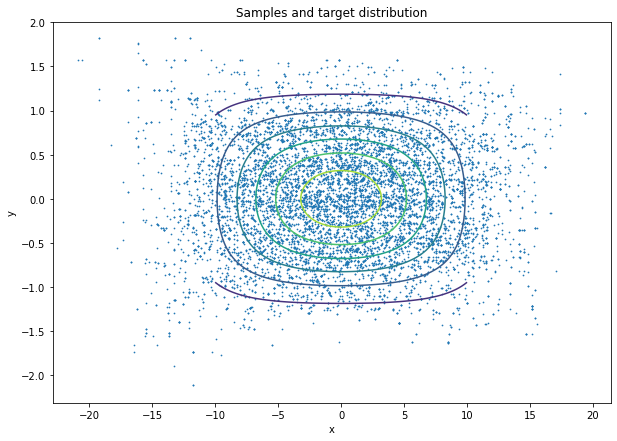

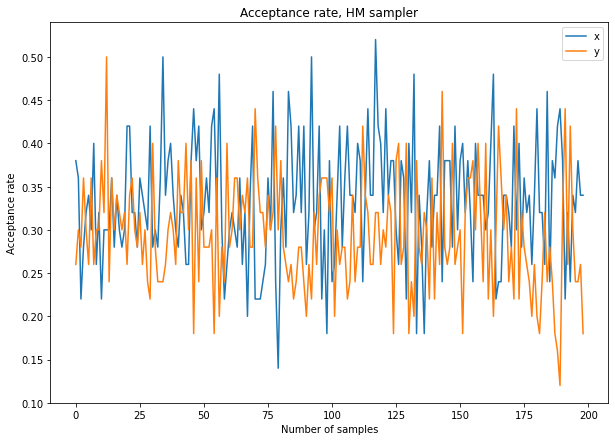

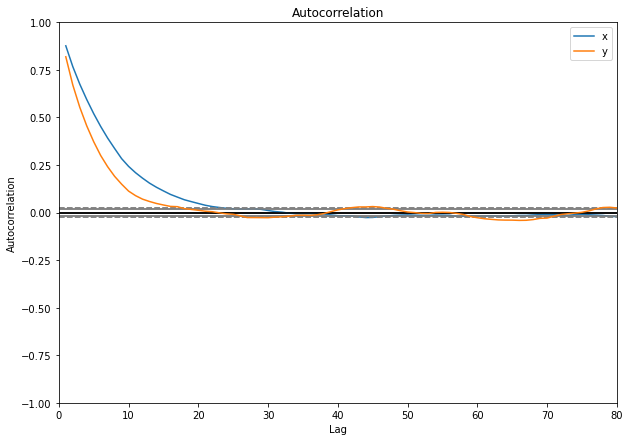

In [88]:
#test the function
N = 10000
a = 10
p=0.5
sigma = [7.5,1]
plot_all(N,a,p,sigma,log_target_dist, sample_P)

> through several tests of various sigma we notice that the higher sigma x is and the lower sigma y is the closer the acceptance is to 0.24 and the convergence of the autocorrelation is more significant 

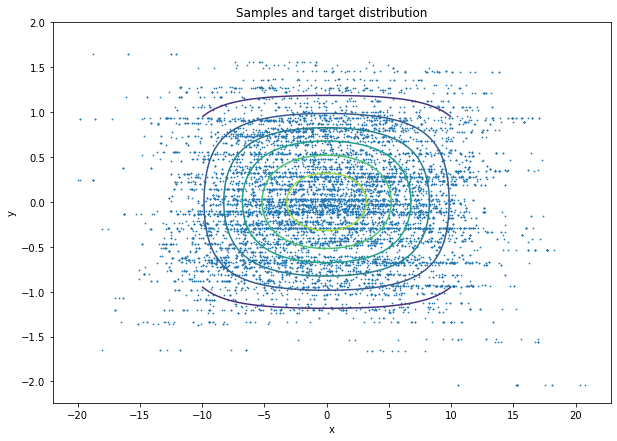

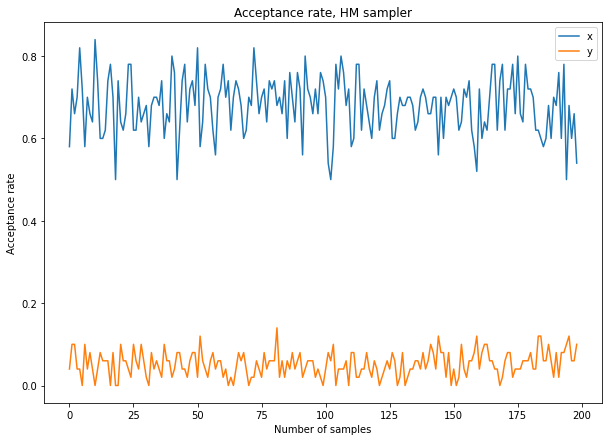

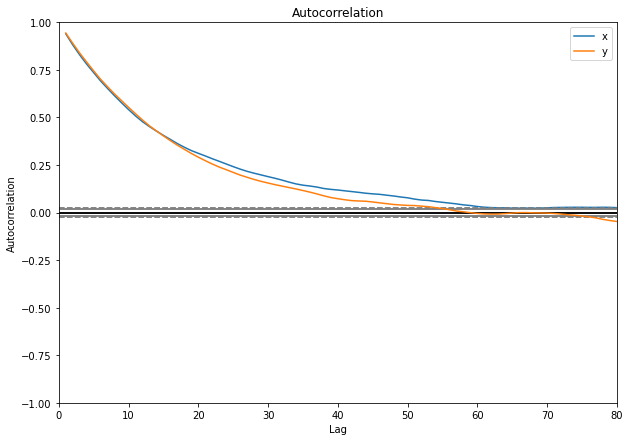

In [89]:
#test the function
N = 10000
a = 10
p=0.8
sigma = [3,3]
plot_all(N,a,p,sigma,log_target_dist, sample_P)


## 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

Let $\pi$ be a density defined on an open set $\mathcal{U}$ of $\mathbb{R}^d, d \geqslant 2$. We consider here a Metropolis-Hastings within Gibbs algorithm to sample from the target density $\pi$. More precisely, the HM-step is a symmetric random walk one and the proposal distribution is a Gaussian distribution centered at the current state.
As usual, for $i \in  [ 1, d ] $, let $\pi_i$ denote the $i$-th full conditional of $\pi$, which is given by:
$$
x_{-i}=\left\{x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_d\right\} \quad ; \quad \pi_i\left(x_i \mid x_{-i}\right) \propto \pi(x)
$$
and $\sigma_i^2$ the variance of the corresponding proposal distribution.

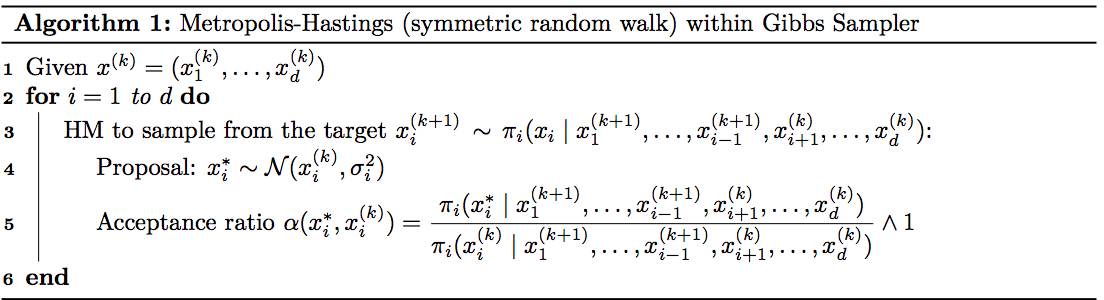

### Question 1

**Implement the adaptative Metropolis-Hastings within Gibbs sampler and test the algorithm on
the density π defined in the part A: Using auto-correlation plots (use a built-in function), compare
the performance of the algorithm with or without adaptation.**

In [117]:
def sample_mcmc_adaptive(N,a,p,sigma):
    x = np.zeros(N)
    y = np.zeros(N)
    #x[0] = np.random.uniform(-1,1)
    #y[0] = np.random.uniform(-1,1)
    #initialize the acceptance rate for x and y
    acc_x = 0
    acc_y = 0
    #initialize the list of acceptance rates
    acc_rate_x = []
    acc_rate_y = []
    #initialize the list of log of the standard deviation
    l_x = np.log(sigma[0])
    l_y = np.log(sigma[1])
    for i in range(1,N):
        #sample a new x and y from sample_P1 and sample_P2
        u=np.random.uniform()
        if u<=p :
          x_new,y_new,alpha,acc = sample_P1(x[i-1],y[i-1],a,np.exp(l_x))
          x[i] = x_new
          y[i] = y_new
          if acc: acc_x += 1
        else:
          x_new,y_new,alpha,acc = sample_P2(x[i-1],y[i-1],a,np.exp(l_y))
          x[i] = x_new
          y[i] = y_new
          if acc: acc_y += 1

        # For each batch 
        if (i % 50 == 0) : 
            #update l_x and l_y
            if acc_x/50 > 0.24:
                l_x += min(0.01,1/np.sqrt(i/50))
            else:
                l_x -= min(0.01,1/np.sqrt(i/50))
            if acc_y/50 > 0.24:
                l_y += min(0.01,1/np.sqrt(i/50))
            else:
                l_y -= min(0.01,1/np.sqrt(i/50))
            acc_rate_x.append(acc_x/50)
            acc_rate_y.append(acc_y/50)
            acc_x = 0 
            acc_y = 0 
            
    return x,y,acc_rate_x,acc_rate_y

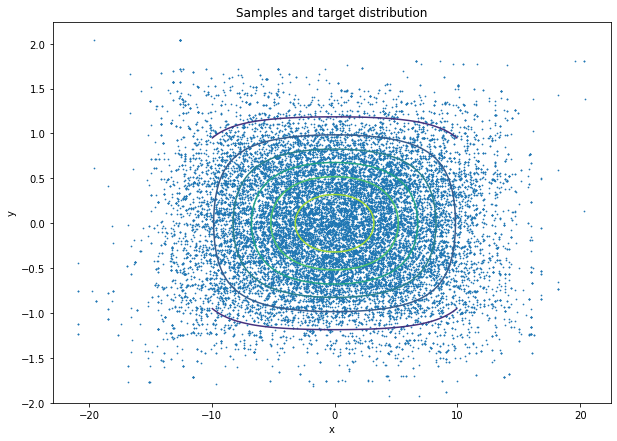

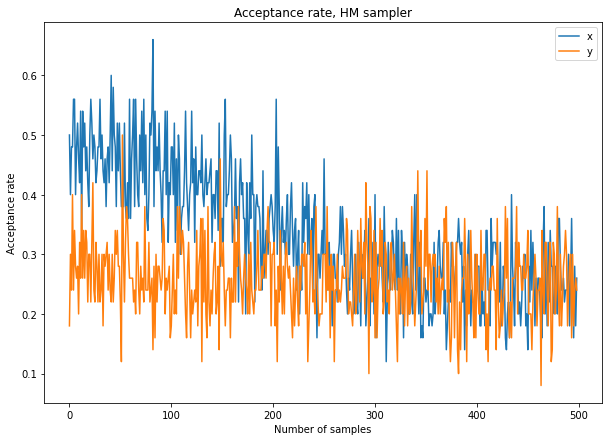

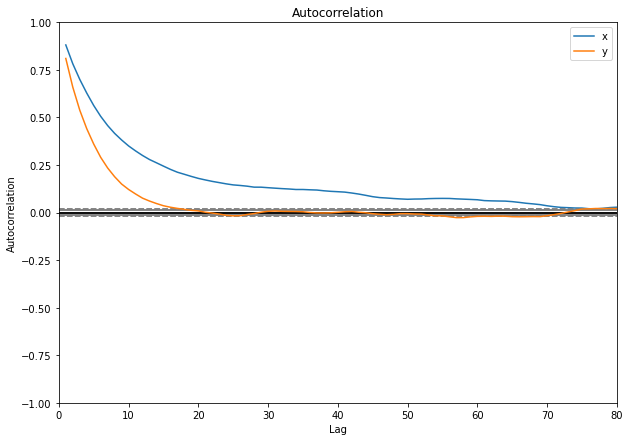

In [125]:
#test the function
N = 25000
a = 10
p=0.5
sigma = [1,1] #to  initialiwe to zero
#plot the samples/ acceptance and correlation
plot_all(N,a,p,sigma,log_target_dist, sample_mcmc_adaptive)

### Question 2

We can also compare the performance of our algorithm on more complicated target densities. For example centered $d$-dimensional Gaussian $\mathcal{N}(0, \Sigma)$ or "banana"-shaped density as in TP2:
$$
\forall x=\left(x_1, \ldots, x_d\right) \in \mathbb{R}^d, \quad f_B(x) \propto \exp \left(-\frac{x_1^2}{200}-\frac{1}{2}\left(x_2+B x_1^2-100 B\right)^2-\frac{1}{2}\left(x_3^2+\ldots+x_d^2\right)\right) .
$$

In practice, you can choose $d = 20$ and $B = 0.1$ for the density $f_B$. You may also choose
$d = 20$ for the second one and use the 20 × 20 variance-covariance matrix $Σ$ given in the file
http://dept.stat.lsa.umich.edu/~yvesa/tmalaexcov.txt.

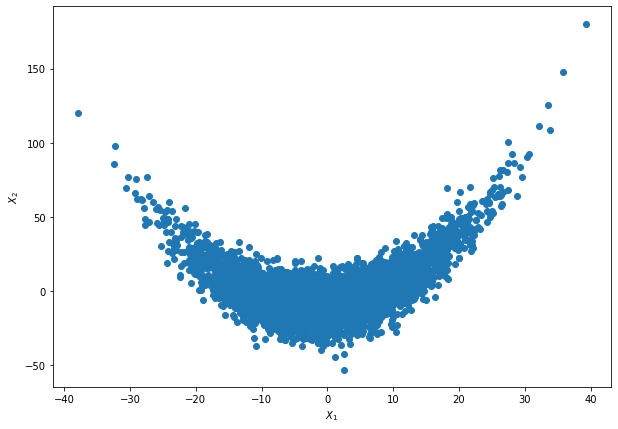

In [128]:
# Parameters 
d=20
B=0.1
sigma = np.array(pd.read_csv('tmalaexcov.txt' ,header=None , sep=' '))


##
data = np.random.multivariate_normal(mean=np.zeros(d),cov=sigma**2,size=5000)
data[:,1] = data[:,1] + B*(data[:,0]**2 - sigma[0,0]**2)

# plot
plt.figure(figsize=(10,7))
plt.scatter(data[:,0],data[:,1])
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

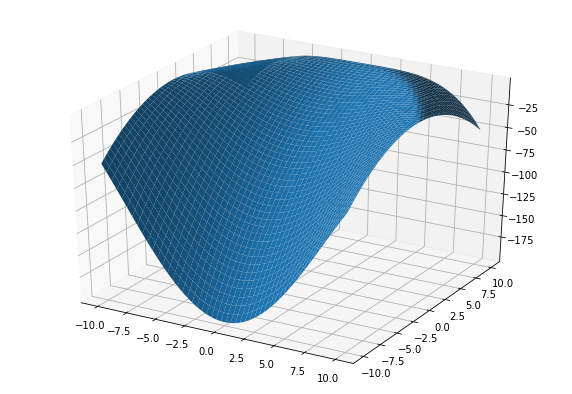

In [131]:
target_fB = lambda x,B: -(x[0]**2)/200.-(0.5)*(x[1]+B*x[0]**2-100*B)**2-(0.5)*(np.sum(x[2:]**2))

x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
X,Y = np.meshgrid(x,y)
Z = target_fB(np.array([X,Y]),B)
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z)
plt.show()

# Exercise 2: Sampling from multimodal distributions

We consider a target distribution $\pi$ with support $\mathcal{U} \subset \mathbb{R}^d\left(d \in \mathbb{N}^*\right)$. When the target distribution is multimodal, especially with well-separated modes, classical MCMC algorithms can perform very poorly and exhibit poor mixing. Indeed, a Metropolis-Hastings algorithm with local proposal can get stuck for a long time in a local mode of the target distribution.

## 2.A – A toy example

In the following, we consider a target distribution $\pi$ - taken from [LW01] and plotted at figure 2 defined on $\mathbb{R}^2$ as a mixture of 20 Gaussian distributions. The target distribution writes:
$$
\pi(\mathbf{x})=\sum_{i=1}^{20} \frac{w_i}{2 \pi \sigma_i^2} \exp \left(-{\frac{1}{2 \sigma_i^2}}^t\left(\mathbf{x}-\boldsymbol{\mu}_i\right)\left(\mathbf{x}-\boldsymbol{\mu}_i\right)\right)
$$
where, $\forall i \in\{1, \ldots, 20\}, w_i=0.05$ and $\sigma_i=0.1$. The 20 means $\boldsymbol{\mu}_i$ are defined as follows:
$$
\begin{gathered}
\left(\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_{20}\right)=\left(\left(\begin{array}{l}
2.18 \\
5.76
\end{array}\right),\left(\begin{array}{c}
8.67 \\
9.59
\end{array}\right),\left(\begin{array}{l}
4.24 \\
8.48
\end{array}\right),\left(\begin{array}{l}
8.41 \\
1.68
\end{array}\right),\left(\begin{array}{l}
3.93 \\
8.82
\end{array}\right),\left(\begin{array}{l}
3.25 \\
3.47
\end{array}\right),\left(\begin{array}{l}
1.70 \\
0.50
\end{array}\right),\right. \\
\left(\begin{array}{l}
4.59 \\
5.60
\end{array}\right),\left(\begin{array}{c}
6.91 \\
5.81
\end{array}\right),\left(\begin{array}{l}
6.87 \\
5.40
\end{array}\right),\left(\begin{array}{l}
5.41 \\
2.65
\end{array}\right),\left(\begin{array}{l}
2.70 \\
7.88
\end{array}\right),\left(\begin{array}{l}
4.98 \\
3.70
\end{array}\right),\left(\begin{array}{l}
1.14 \\
2.39
\end{array}\right), \\
\left.\left(\begin{array}{l}
8.33 \\
9.50
\end{array}\right),\left(\begin{array}{c}
4.93 \\
1.50
\end{array}\right),\left(\begin{array}{c}
1.83 \\
0.09
\end{array}\right),\left(\begin{array}{c}
2.26 \\
0.31
\end{array}\right),\left(\begin{array}{l}
5.54 \\
6.86
\end{array}\right),\left(\begin{array}{c}
1.69 \\
8.11
\end{array}\right)\right)
\end{gathered}
$$

### Question 1

**Write a Metropolis-Hastings Symmetric Random Walk algorithm (you may use your code from previous tutorial classes) to sample from $\pi$.**

In [3]:
#target ditribution 
def pi (x,mu,sigma,w):
    #x: 2x1 vector
    pi_ = 0
    for i in range(len(mu)):
        pi_ += w/(2*np.pi*sigma**2) * np.exp(-np.linalg.norm(x-mu[i,:])**2/(2*sigma**2))
    return pi_


In [4]:

def plot_target(mu,sigma,w):
    x = np.linspace(0,10,100)
    y = np.linspace(0,10,100)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            Z[i,j] = pi(np.array([X[i,j],Y[i,j]]),mu,sigma,w)
    plt.figure(figsize=(10,5))
    plt.contourf(X,Y,Z,100)
    plt.colorbar()
    plt.title("Target Distribution")
    plt.show()
    plt.figure(figsize=(10,5))
    ax = plt.gca(projection='3d')
    ax.plot_surface(X,Y,Z,cmap="viridis")
    plt.title("3D Plot of Target Distribution")
    plt.show()

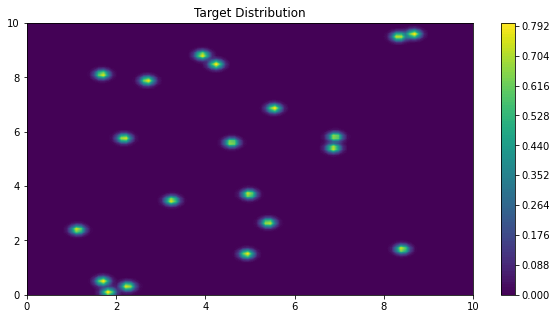

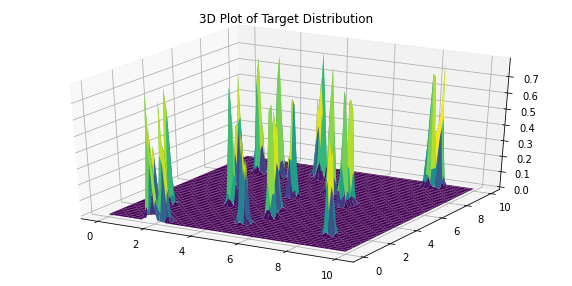

In [5]:
#plot the target distribution
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
               [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
               [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])
sigma = 0.1
w = 0.05

plot_target(mu,sigma,w)

In [6]:
def sample_target(N,mu,sigma,w):
    #N: number of samples
    #mu: 20x2 matrix of means
    #sigma: variance
    #w: weight of each gaussian
    x = np.zeros((N,2))
    x[0,:] = np.random.uniform(0,10,2)
    acc = 0
    acc_rate = []
    for i in range(1,N):
        x_new = x[i-1,:] + np.random.normal(0,1,2)
        alpha = pi(x_new,mu,sigma,w)/pi(x[i-1,:],mu,sigma,w)
        if alpha >= 1:
            x[i,:] = x_new
            acc += 1
        else:
            u = np.random.uniform(0,1)
            if u <= alpha:
                x[i,:] = x_new
                acc += 1
            else:
                x[i,:] = x[i-1,:]
        if i%100 == 0:
            acc_rate.append(acc/50)
            acc = 0
    return x, acc_rate

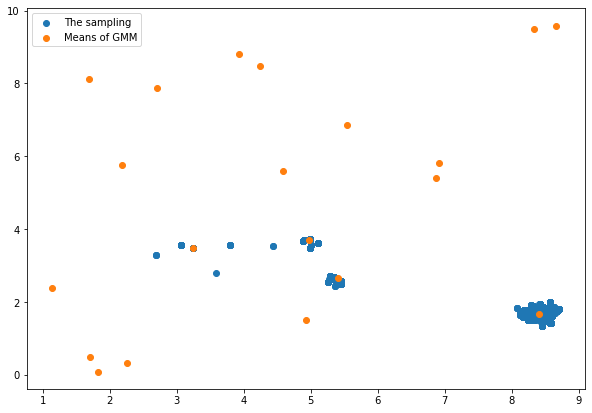

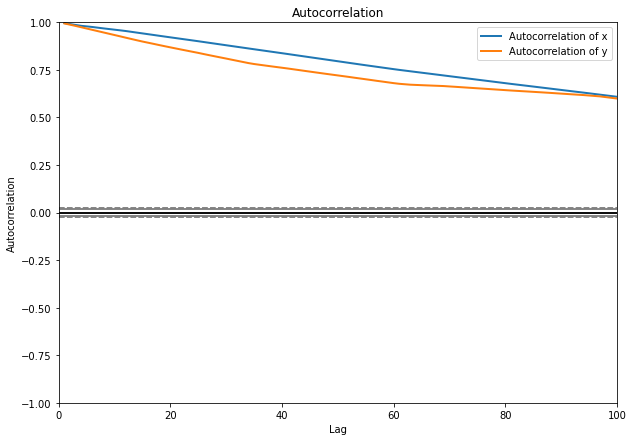

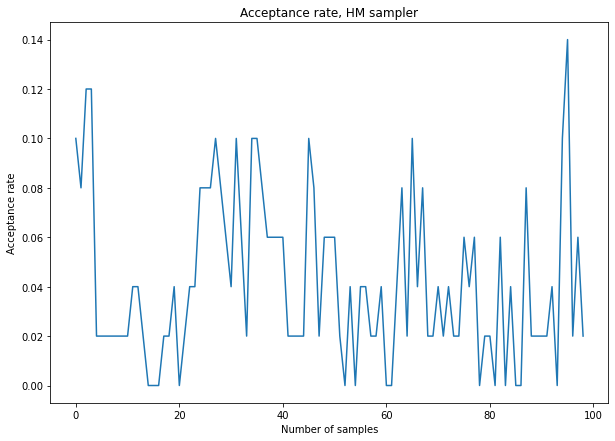

In [7]:
#parameters
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
               [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
               [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])
sigma = 0.1
w = 0.05

# Test the algorithm 
samples,acc_rate = sample_target(10000,mu, sigma, w)
      
    
# Plots 
plt.figure(figsize=(10,7))
plt.scatter(samples[:,0],samples[:,1] , label = 'The sampling')
plt.scatter(mu[:,0],mu[:,1], label = 'Means of GMM')
plt.legend()
plt.show()

#autocorrelation 
plt.figure(figsize=(10,7))
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
pd.plotting.autocorrelation_plot(samples[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(samples[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

#plot the acceptance rate 
plt.figure(figsize=(10,7))
plt.title('Acceptance rate, HM sampler')
plt.xlabel('Number of samples')
plt.ylabel('Acceptance rate')
plt.plot(acc_rate)
plt.show()

### Question 2

Show that the Metropolis-Hastings algorithm (even the adaptive Metropolis-Hastings algorithm) fails to sample from $\pi$.

In [8]:
def sample_mcmc_adaptive(N,mu,sigma,w):
    #N: number of samples
    #mu: 20x2 matrix of means
    #sigma: variance
    #w: weight of each gaussian
    x = np.zeros((N,2))
    x[0,:] = np.random.uniform(0,10,2)
    acc = 0
    acc_rate = []
    l = np.log(sigma)
    for i in range(1,N):
        x_new = x[i-1,:] + np.random.normal(0,np.exp(l),2)
        alpha = min(1,pi(x_new,mu,sigma,w)/pi(x[i-1,:],mu,sigma,w))
        u = np.random.uniform(0,1)
        if u <= alpha:
            x[i,:] = x_new
            acc += 1
        else:
            x[i,:] = x[i-1,:]
        if i%50 == 0:
            if acc/50 > 0.24:
                l += min(0.01,1/np.sqrt(i/50))
            else:
                l -= min(0.01,1/np.sqrt(i/50))
            acc_rate.append(acc/50)
            acc = 0
    return x, acc_rate

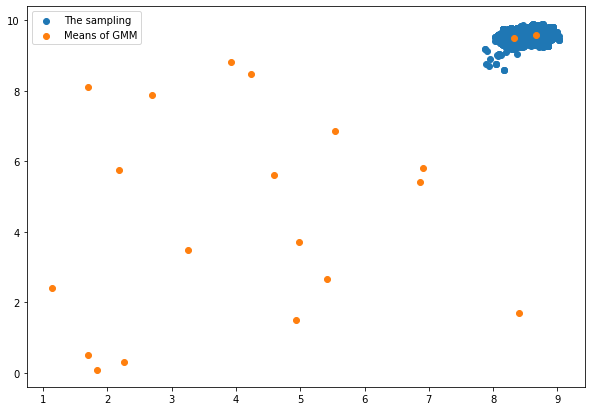

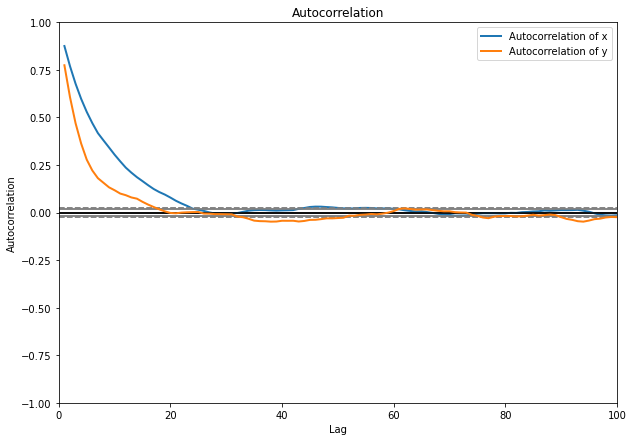

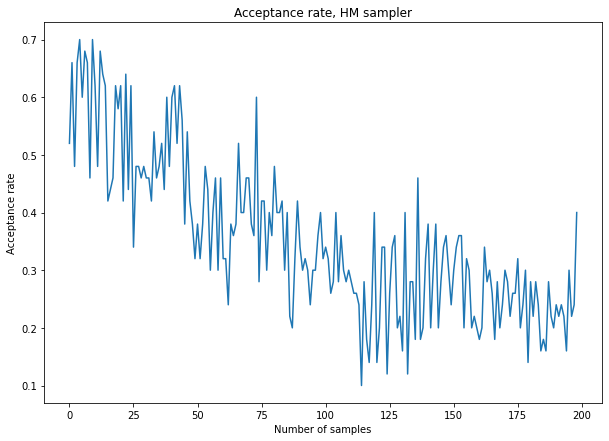

In [9]:
# Test the algorithm 
samples,acc_rate = sample_mcmc_adaptive(10000,mu, sigma, w)
      
    
# Plots 
plt.figure(figsize=(10,7))
plt.scatter(samples[:,0],samples[:,1] , label = 'The sampling')
plt.scatter(mu[:,0],mu[:,1], label = 'Means of GMM')
plt.legend()
plt.show()

#autocorrelation 
plt.figure(figsize=(10,7))
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
pd.plotting.autocorrelation_plot(samples[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(samples[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

#plot the acceptance rate 
plt.figure(figsize=(10,7))
plt.title('Acceptance rate, HM sampler')
plt.xlabel('Number of samples')
plt.ylabel('Acceptance rate')
plt.plot(acc_rate)
plt.show()

## 2.B – Parallel Temperin

The general idea of the Parallel Tempering (PT) [Gey91, ED05] algorithm is to use tempered versions of the distribution $\pi$ and run parallel Metropolis-Hastings algorithm to sample from these tempered distributions. The tempered distributions are obtained by "warming up" the target distribution $\pi$ at different temperatures. At each iteration of the algorithm, a swap between two chains (chains running at different temperature levels) is proposed. The Parallel Tempering uses the fast mixing of the chains at high temperature to improve the mixing of the chains at low temperatures.

Let $K$ denote a positive integer. We consider a sequence of temperatures $\left(T_{i}\right)_{1 \leq i \leq K}$ such that:

$$
T_{1}>T_{2}>\ldots>T_{K}=1 \text {. }
$$

In the Parallel Tempering algorithm, $K$ chains run in parallel: for $i \in [ 1, K ]$, the $i$-th chain targets the tempered distribution $\pi_{i}:=\pi^{1 / T_{i}}$; the distribution of interest corresponds to the lowest temperature, $T_{K}=1$. Let $\left(X_{n}^{(i)}\right)_{n \in \mathbb{N}}$ denote the $i$-th chain, sampling from the tempered distribution $\pi_{i}$.

At the $n$-th iteration of the Parallel Tempering algorithm, a candidate $Y_{n+1}^{(i)}$ for the $i$-th chain is proposed using the transition kernel $P^{(i)}\left(X_{n}^{(i)}, \cdot\right)$ of a Metropolis-Hastings algorithm. The next step consists in proposing a swap between two different chains (running at different temperatures): given $(i, j) \in [ 1, K ]^{2}$, with $i \neq j$, a swap is proposed with probability $\alpha(i, j)$.


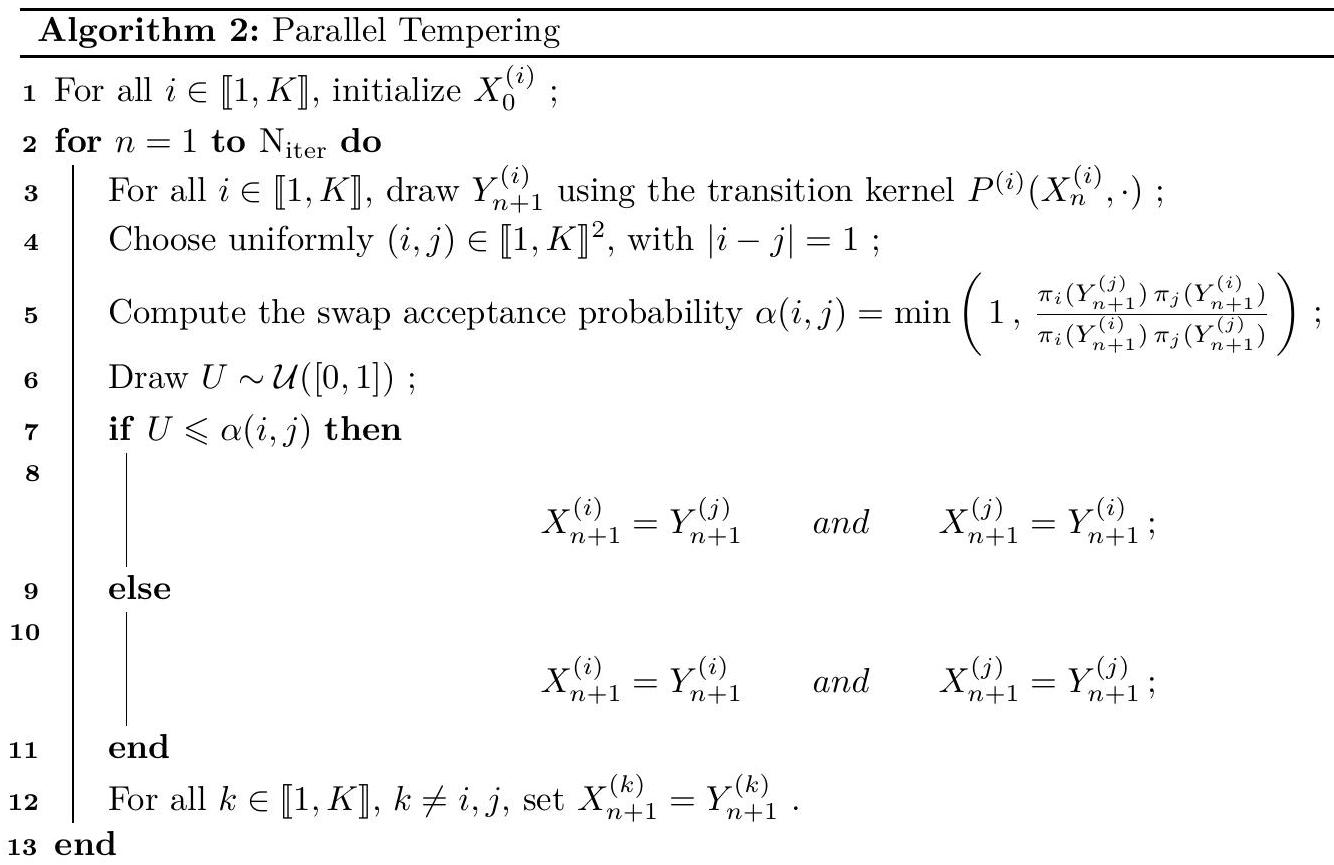

### Question 1

**Implement the Parallel Tempering algorithm**

In [10]:
def parallel_tempering(T , mu , sigma , w , N): 
    
    X = np.zeros((len(T),N+1,2))
    #initialze X0 for each tempeture
    for i in range(len(T)):
        X[i,0,:] = np.random.rand(2)
    
    #the iteration loop
    for n in range(N):
        # Draw Y for all i in [1,K]
        for i in range(len(T)): 
            
            t = T[i]
            Y = np.random.normal(X[i,n,:],0.25*np.sqrt(t),2)
            log_alpha = min(0 , np.log(pi(Y,mu,sigma,w))/t - 
                            np.log(pi(X[i,n+1,:],mu,sigma,w))/t)
            if np.log(np.random.rand()) <= log_alpha: 
                X[i,n+1,:] = Y
            else: 
                X[i,n+1,:] = X[i,n,:] 
        
       
        # Choose i and j |i − j| = 1
        i = np.random.randint(0,len(T)) 
        j = np.random.choice([i-1 , i+1]) 
        if i == 0 : j = i+1
        if i == len(T)-1 : j = i-1
            
        
        ## Compute the swap acceptance probability
        
        alpha_i = (pi(X[j,n+1,:],mu,sigma,w)**(1/T[i])) * (pi(X[i,n+1,:],mu,sigma,w)**(1/T[j]))
        alpha_j = (pi(X[i,n+1,:],mu,sigma,w)**(1/T[i])) * (pi(X[j,n+1,:],mu,sigma,w)**(1/T[j]))
        alpha = min(1, alpha_i / alpha_j)
    
        u = np.random.rand()<alpha
        if u <= alpha : 
            X[i,n+1,:], X[j,n+1,:] = X[j,n+1,:], X[i,n+1,:]
    return X

### Question 2

In order to illustrate the performance of the algorithm, use your code to sample from the distribution $\pi$ of Part A. Use the algorithm with $K=5$ and with the following temperatures ladder:
$$
\left(T_{1}, \ldots, T_{5}\right)=(60,21.6,7.7,2.8,1) .
$$

For the Metropolis-Hastings step (line 3), take as proposal distribution the bivariate Gaussian distribution centered at $X_{n}^{(i)}$, with variance-covariance matrix $\tau_{i}^{2} \mathrm{I}_{2}$ :

$$
\forall i \in [ 1, K ], \quad Y_{n+1}^{(i)} \sim \mathcal{N}_{\mathbb{R}^{2}}\left(X_{n}^{(i)}, \tau_{i}^{2} \mathrm{I}_{2}\right) \quad \text { where } \quad \tau_{i}=0.25 \sqrt{T_{i}}
$$

The scale parameters $\tau_{i}$ are tuned to ensure a reasonable acceptance rate in the algorithm.

In practice, the performance of the Parallel Tempering algorithm strongly depends on the choice of the temperatures ladder, the number of chains and the choice of proposal kernels. For most distributions, tuning these parameters may be infeasible. In [MMV13], the authors have proposed an adaptive Parallel Tempering algorithm to address these difficulties.

<ipython-input-10-543dd78983db>:15: RuntimeWarning: divide by zero encountered in log
  log_alpha = min(0 , np.log(pi(Y,mu,sigma,w))/t -


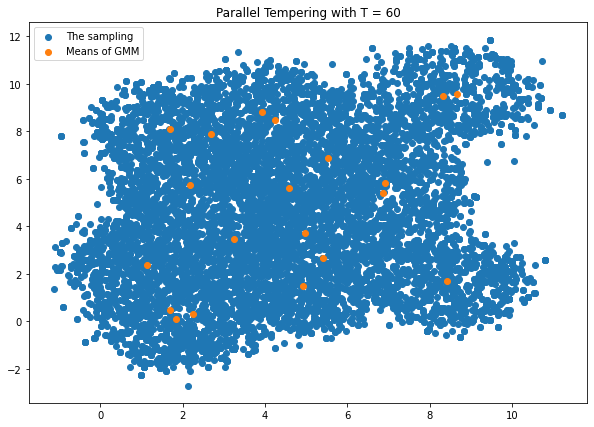

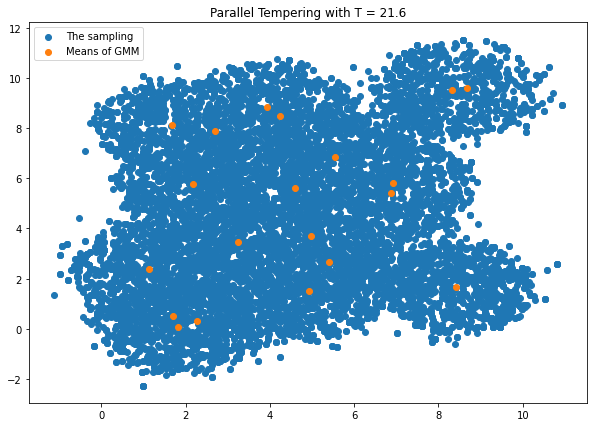

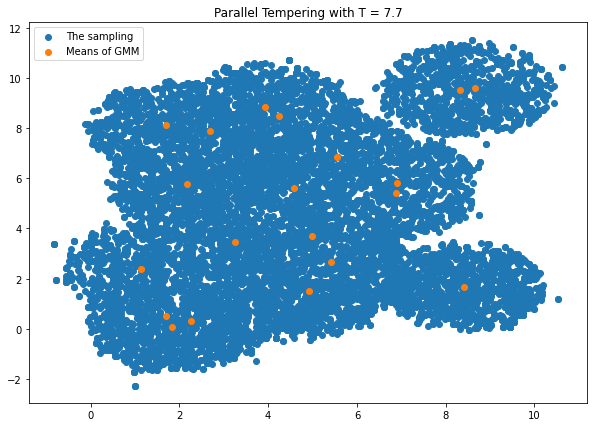

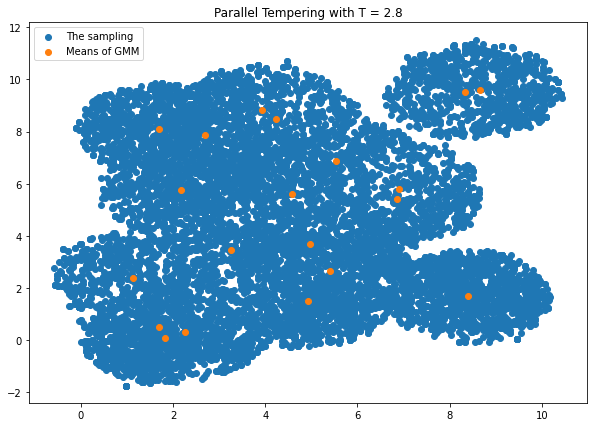

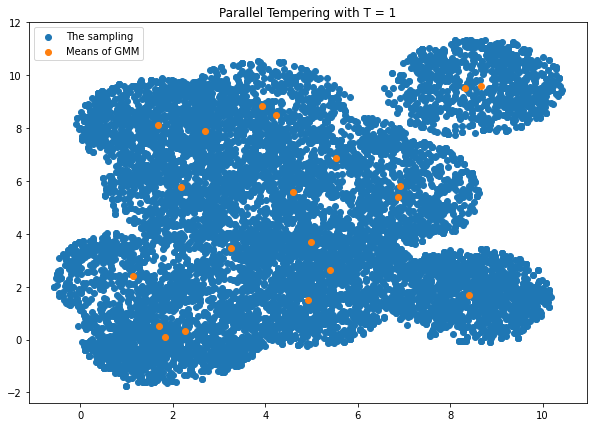

In [11]:
# Variables  for test 
T = [60,21.6,7.7,2.8,1]
N= 10000
sigma = 0.1
w = 0.05
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
               [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
               [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])

# Run the parallel tempering algorithm and plot for each temperature
X = parallel_tempering(T , mu , sigma , w , N)
for i in range(5): 
    plt.figure(figsize=(10,7))
    plt.scatter(X[i,:,0],X[i,:,1] , label = 'The sampling')
    plt.scatter(mu[:,0],mu[:,1], label = 'Means of GMM')
    plt.legend()
    plt.title('Parallel Tempering with T = ' + str(T[i]))
    plt.show()

# Exercise 3: Bayesian analysis of a one-way random effects model

We recall that the density of an Inverse Gamma distribution with positive parameters (a, b) is proportional to
$$
x \mapsto \frac{1}{x^{a+1}} \exp \left(-\frac{b}{x}\right) \mathbb{1}_{\mathbb{R}^{+}}(x)
$$
and especially that we can sample $y$ from the inverse gamma distribution of parameters $(a, b)$ by generating $x$ from a gamma distribution of parameters $\left(a, \frac{1}{b}\right)$ and then taking $y=\frac{1}{x}$. We also recall that we can find a Matlab toolbox-free Gamma Generator in the Handbook of Monte Carlo Methods [KTB13]: https://people.smp.uq.edu.au/DirkKroese/montecarlohandbook/probdist/. Otherwise, we can use directly scipy.stats.invgamma or the Statistics and Machine Learning Toolbox in Matlab.

Let suppose we collect the observations $Y=\left\{y_{i, j}, i \in [ 1, N ], j \in [ 1, k_i ]\right\}$ and set $k:=\sum_{i=1}^N k_i$ the total number of observations. Let the following random effects model:
(i) $y_{i, j}$ is a realization of the variable $Y_{i, j}$ where $Y_{i, j}=X_i+\varepsilon_{i, j}$;
(ii) The random effects $X=\left\{X_i, i \in [ 1, N ]\right\}$ are i.i.d from a Gaussian $\mathcal{N}\left(\mu, \sigma^2\right)$ and independent of the errors $\varepsilon=\left\{\varepsilon_{i, j}, i \in [ 1, N ], j \in [ 1, k_i ]\right\}$;
(iii) The errors $\varepsilon$ are i.i.d from the centred Gaussian $\mathcal{N}\left(0, \tau^2\right)$;
where $(\mu, \sigma, \tau)$ are the unknown parameters. Bayesian analysis using this model requires specifying a prior distribution, for which we consider:
$$
\pi_{\text {prior }}\left(\mu, \sigma^2, \tau^2\right) \propto \frac{1}{\sigma^{2(1+\alpha)}} \exp \left(-\frac{\beta}{\sigma^2}\right) \frac{1}{\tau^{2(1+\gamma)}} \exp \left(-\frac{\beta}{\tau^2}\right)
$$
where $\alpha, \beta$ and $\gamma$ are known hyper-parameters.

## Question 1

**Write the density of the a posteriori distribution $\left(X, \mu, \sigma^2, \tau^2\right)$ - it can be given up to a normalizing constant - i.e the density of the distribution $\left(Y, X, \mu, \sigma^2, \tau^2\right)$.**



```
ANSWER 
```



\begin{aligned}
q(X,μ,\sigma^2,\tau^2 \mid y)=\frac{q(y \mid X,μ,\sigma^2,\tau^2)q(X,μ,\sigma^2,\tau^2)}{q(y)}
\end{aligned}
$with$ $q(y) ← cst$ and $q(y \mid X,μ,\sigma^2,\tau^2)  ∼N(X,\tau^2)$

We compute $q(X,μ,\sigma^2,\tau^2)$
\begin{aligned}
q(X,μ,\sigma^2,\tau^2)&= q(X \mid μ,\sigma^2,\tau^2)\pi_{prior}(μ,\sigma^2,\tau^2)
\end{aligned}
Hence,
\begin{aligned}
q(X,μ,\sigma^2,\tau^2 \mid y)&∝q(y \mid X,μ,\sigma^2,\tau^2) \times q(X \mid μ,\sigma^2,\tau^2) \times \pi_{prior}(μ,\sigma^2,\tau^2)
\end{aligned}
with 
\begin{aligned}
&-q\left(Y \mid X, \mu, \sigma^2, \tau^2\right) \propto\left(\frac{1}{\tau^2}\right)^{\frac{N k}{2}} \exp \left(-\frac{\sum_i^N \sum_j^{k_i\left(y_{i, j}-X_i\right)^2}}{2 \tau^2}\right)\\
&-q\left(X \mid \mu, \sigma^2, \tau^2\right) \propto\left(\frac{1}{\sigma^2}\right)^{\frac{N}{2}} \exp \left(-\frac{\sum_i^N\left(X_i-\mu\right)^2}{2 \sigma^2}\right)\\
&-\pi_{prior}\left(\mu, \sigma^2, \tau^2\right) \propto \frac{1}{\sigma^{2(1+\alpha)}} \exp \left(-\frac{\beta}{\sigma^2}\right) \frac{1}{\tau^2(1+\gamma)} \exp \left(-\frac{\beta}{\tau^2}\right)
\end{aligned}
\begin{aligned}
 q\left(X, \mu, \sigma^2, \tau^2 \mid Y\right) &\propto\left(\frac{1}{\tau^2}\right)^{\frac{N k}{2}} \exp \left(-\frac{\sum_i^N \sum_j^{k_i}\left(y_{i, j}-X_i\right)^2}{2 \tau^2}\right) \times\left(\frac{1}{\sigma^2}\right)^{\frac{N}{2}} \exp \left(-\frac{\sum_i^N\left(X_i-\mu\right)^2}{2 \sigma^2}\right) \times \frac{1}{\sigma^{2(1+\alpha)}} \exp \left(-\frac{\beta}{\sigma^2}\right) \frac{1}{\tau^{2(1+\gamma)}} \exp \left(-\frac{\beta}{\tau^2}\right)\\
q\left(X, \mu, \sigma^2, \tau^2 \mid Y\right) &\propto\left(\frac{1}{\tau^2}\right)^{\frac{N k}{2}+\gamma+1}\left(\frac{1}{\sigma^2}\right)^{\frac{N}{2}+\alpha+1} \exp \left(-\frac{\sum_i^N \sum_j^{k_i}\left(y_{i, j}-X_i\right)^2}{2 \tau^2}-\frac{\sum_i^N\left(X_i-\mu\right)^2}{2 \sigma^2}-\frac{\beta}{\sigma^2}-\frac{\beta}{\tau^2}\right)
\end{aligned}



## Question 2

**Implement a Gibbs sampler which updates in turn $\left(\sigma^2, \tau^2, \mu, X\right)$ one at a time.**

**First $q\left(\sigma^2 \mid Y, X, \mu, \tau^2\right)$**
$$
q\left(\sigma^2 \mid Y, X, \mu, \tau^2\right) \propto\left(\frac{1}{\sigma^2}\right)^{\frac{N}{2}+\alpha+1} \exp \left(-\frac{\sum_i^N\left(X_i-\mu\right)^2}{2 \sigma^2}-\frac{\beta}{\sigma^2}\right)
$$
which is proportional to an Inverse Gamma Distribution of parameters $\left(\frac{N}{2}+\alpha, \frac{\sum_i^N\left(X_i-\mu\right)^2}{2}+\beta\right)$


**Then $q\left(\tau^2 \mid Y, X, \mu, \sigma^2\right)$**
$$
q\left(\tau^2 \mid Y, X, \mu, \sigma^2\right) \propto\left(\frac{1}{\tau^2}\right)^{\frac{N k}{2}+\gamma+1} \exp \left(-\frac{\sum_i^N \sum_j^{k_i}\left(y_{i, j}-X_i\right)^2}{2 \tau^2}-\frac{\beta}{\tau^2}\right)
$$
which is proportional to an Inverse Gamma Distribution of parameters $\left(\frac{N k}{2}+\gamma, \frac{\sum_i^N \sum_j^{k_j}\left(y_{i j}-X_i\right)^2}{2}+\beta\right)$


**For $q(\mu|Y,X,\sigma^2,\tau^2)$**
\begin{aligned}
q(\mu|Y,X,\sigma^2,\tau^2)&\propto exp(-\frac{\sum_{i}^N (X_i-\mu)^2}{2\sigma^2})\\
&\propto exp(-\frac{( \frac{ \sum_{i}^N X_i}{N} - \mu)^2}{2 \frac{\sigma^2}{N}})
\end{aligned}


which is proportional to the density of a gaussian distribution with parameters $(\frac{ \sum_{i}^N X_i}{N}, \frac{\sigma^2}{N})$
 
 
**Finally $q(X|Y,\mu,\sigma^2,\tau^2)$**
\begin{aligned} 
q(X|Y,\mu,\sigma^2,\tau^2) & \propto exp(-\frac{\sum_{i}^N (X_i-\mu)^2}{2\sigma^2}) exp(-\frac{\sum_{i}^N \sum_{j}^{k_i} (y_{i,j}-X_i)^2}{2\tau^2})\\
& \propto \prod_i^N exp(- \frac{((\frac{\tau^2 \mu + \sigma^2 \sum_j^{k_i} y_{i,j}}{\tau^2 + k_i \sigma^2})- X_i)^2}{2 \frac{\sigma^2 \tau^2}{\tau^2 + k_i \sigma^2}} )
\end{aligned} 

which is proportional to the density of a gaussian distribution with parameters $(\frac{\tau^2 \mu + \sigma^2 \sum_j^{k_i} y_{i,j}}{\tau^2 + k_i \sigma^2},\frac{\sigma^2 \tau^2}{\tau^2 + k_i \sigma^2})$
 

In [16]:
def Gibbs_sampler(Y , beta , alpha , gamma , N, k ,N_samples) :
        
        # Initiate Variables 
        sigma = []
        sigma_ = np.random.gamma(shape= 1 , scale=1)
        tau = []
        tau_ = np.random.gamma(shape= 1 , scale=1)
        mu = []
        mu_ = np.random.normal(loc = 0 , scale=1)
        X = []
        X_ = np.random.normal(loc = 0 , scale=1, size=N)
        
        for i in range(N_samples):
            # Sample from distributions
            sigma_new = 1 / np.random.gamma(shape= N/2 + alpha , scale=1/(beta + np.sum((X_- mu_)**2)/2))
            tau_new = 1 / np.random.gamma(shape= N*k/2 + gamma , scale=1/(beta + np.sum((Y.T - X_)**2)/2))
            mu_new = np.random.normal(loc = np.mean(X_), scale=np.sqrt(sigma_/N))
            X_new = np.array([np.random.normal(loc = (tau_ * mu_ + sigma_*np.sum(Y[j,:]))/(k * sigma_ + tau_), scale=np.sqrt((sigma_*tau_)/(k * sigma_ + tau_))) for j in range(N)])
            # append the new values
            sigma.append(sigma_new)
            tau.append(tau_new)
            mu.append(mu_new)
            X.append(X_new)
            # update the variables
            sigma_,tau_,mu_,X_ = sigma_new,tau_new,mu_new,X_new
        return sigma, tau , mu, X